In [157]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import polars as pl
import altair as alt
import mplfinance as mpf
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import requests
from scipy import stats

In [156]:
pdf_raw = pd.read_parquet("data/silver/stock_daily_candle.parquet")

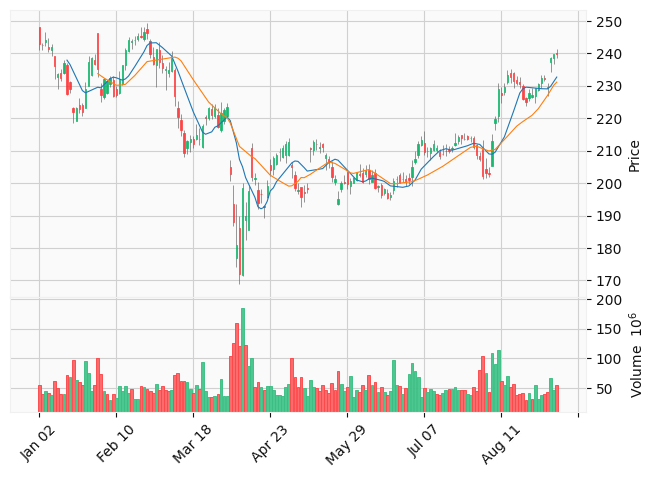

In [3]:
data = pdf_raw
data = data[
    (data["ticker"] == "AAPL") & (data["date"] > datetime.date(2025, 1, 1))
].sort_values("date")
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
# Now, plot the candlestick chart
mpf.plot(data, type="candle", style="yahoo", volume=True, mav=(10, 20))

In [17]:
data[data.index > '2025-08-01']

,ticker,high,low,open,close,volume
date,,,,,,
2025-08-04,AAPL,207.644355,201.451371,204.278165,203.119492,75109300.0
2025-08-05,AAPL,205.107211,201.930824,203.169408,202.689957,44155100.0
2025-08-06,AAPL,215.135845,205.356935,205.396898,213.008255,108483100.0
2025-08-07,AAPL,220.599641,216.334477,218.631873,219.780563,90224800.0
2025-08-08,AAPL,230.738135,219.001455,220.579666,229.090012,113854000.0
2025-08-11,AAPL,229.559998,224.759995,227.919998,227.179993,61806100.0
2025-08-12,AAPL,230.800003,227.070007,228.009995,229.649994,55626200.0
2025-08-13,AAPL,235.000000,230.429993,231.070007,233.330002,69878500.0
2025-08-14,AAPL,235.119995,230.850006,234.059998,232.779999,51916300.0


In [ ]:
def is_pivot(df, index, window):
    if index < window or index >= df.shape[0]-window:
        return 0
    pivot_low = 2 * ~(df.iloc[index].low > df.iloc[index - window : index + window + 1].low.min())
    pivot_high = 1 * ~(
        df.iloc[index].high < df.iloc[index - window : index + window + 1].high.max()
    )
    return pivot_high + pivot_low


def pointpos(x):
    if x["is_pivot"] == 2:
        return x["low"] - 1e-3
    elif x["is_pivot"] == 1:
        return x["high"] + 1e-3


def collect_channel(df, candle, backcandles, window):
    localdf = df[candle - backcandles - window : candle - window]
    localdf["is_pivot"] = localdf.apply(lambda x: is_pivot(df, x.date, window), axis=1)
    highs = localdf[localdf["is_pivot"] == 1].High.values
    idxhighs = localdf[localdf["is_pivot"] == 1].High.index
    lows = localdf[localdf["is_pivot"] == 2].Low.values
    idxlows = localdf[localdf["is_pivot"] == 2].Low.index

    if len(lows) >= 2 and len(highs) >= 2:
        sl_lows, interc_lows, r_value_l, _, _ = stats.linregress(idxlows, lows)
        sl_highs, interc_highs, r_value_h, _, _ = stats.linregress(idxhighs, highs)

        return (
            sl_lows,
            interc_lows,
            sl_highs,
            interc_highs,
            r_value_l**2,
            r_value_h**2,
        )
    else:
        return (0, 0, 0, 0, 0, 0)


df_data = data.copy(deep=True)
df_data = df_data#[df_data.index > date_filter]
df_thingy= collect_channel(df_data, 10, 100, 3)
# df_data = df_data[df_data.index > date_filter]
# df_data["is_pivot"] = [is_pivot(df_data,i, 5) for i in range(df_data.shape[0])]
# df_data["pointpos"] = df_data.apply(lambda row: pointpos(row), axis=1)

df_thingy

# extra_plots = [
#     mpf.make_addplot(df_data["pointpos"], type="pnf", color="#111111", panel=2),
# ]

# mpf.plot(
#     df_data,
#     type="candle",
#     style="yahoo",
#     volume=True,
#     addplot=extra_plots,
#     mav=(10, 20),
# )

ValueError: Cannot set a DataFrame with multiple columns to the single column is_pivot

In [ ]:
df = data
candle = 10
backcandles = 100
window = 3


localdf = df[candle - backcandles - window : candle - window]
print(localdf)
print(localdf.apply(lambda x: is_pivot(df, x.date, window), axis=1))
# localdf["is_pivot"] = localdf.apply(lambda x: is_pivot(df, x.date, window), axis=1)
# highs = localdf[localdf["is_pivot"] == 1].High.values
# idxhighs = localdf[localdf["is_pivot"] == 1].High.index
# lows = localdf[localdf["is_pivot"] == 2].Low.values
# idxlows = localdf[localdf["is_pivot"] == 2].Low.index

# if len(lows) >= 2 and len(highs) >= 2:
#     sl_lows, interc_lows, r_value_l, _, _ = stats.linregress(idxlows, lows)
#     sl_highs, interc_highs, r_value_h, _, _ = stats.linregress(idxhighs, highs)

#     print (
#         sl_lows,
#         interc_lows,
#         sl_highs,
#         interc_highs,
#         r_value_l**2,
#         r_value_h**2,
#     )
# else:
#     print(0, 0, 0, 0, 0, 0)

           ticker        high         low        open       close      volume
date                                                                         
2025-01-17   AAPL  231.468300  227.671779  231.298903  229.166473  68488300.0
2025-01-21   AAPL  223.626134  218.603970  223.207622  221.852432  98070400.0
2025-01-22   AAPL  223.327191  219.012506  219.012506  223.038223  64126500.0
2025-01-23   AAPL  226.226925  221.513661  223.945032  222.868851  60234800.0
2025-01-24   AAPL  224.831868  220.626794  223.984869  221.991943  54697900.0
...           ...         ...         ...         ...         ...         ...
2025-05-21   AAPL  206.805286  200.482476  204.937411  201.860901  59211800.0
2025-05-22   AAPL  202.520153  199.473607  200.482472  201.131729  46742400.0
2025-05-23   AAPL  197.475883  193.240699  193.450453  195.048645  78432900.0
2025-05-27   AAPL  200.512445  197.206185  198.075209  199.983047  56288500.0
2025-05-28   AAPL  202.500174  199.673380  200.362600  200.19279

AttributeError: 'Series' object has no attribute 'date'

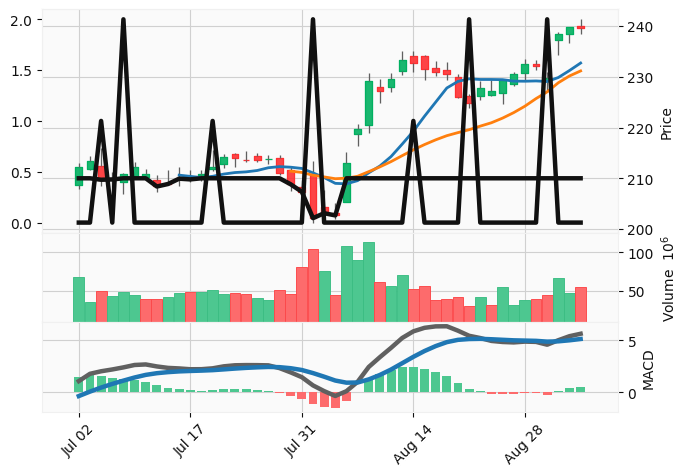

In [ ]:
# Add MACD as subplot
date_filter = '2025-07-01'
def MACD(df, window_slow, window_fast, window_signal):
    macd = pd.DataFrame()
    macd["ema_slow"] = df["close"].ewm(span=window_slow).mean()
    macd["ema_fast"] = df["close"].ewm(span=window_fast).mean()
    macd["macd"] = macd["ema_slow"] - macd["ema_fast"]
    macd["signal"] = macd["macd"].ewm(span=window_signal).mean()
    macd["diff"] = macd["macd"] - macd["signal"]
    macd["bar_positive"] = macd["diff"].map(lambda x: x if x > 0 else 0)
    macd["bar_negative"] = macd["diff"].map(lambda x: x if x < 0 else 0)
    return macd

def channel(df):
    chnl = df.copy(deep=True)
    chnl["upper"] = [isPivot(df, i, 3) for i in range(data.shape[0])]
    chnl["lower"] = df["close"].map(lambda x: x if x < 210 else 210)
    return chnl

df_data = data

macd = MACD(df_data, 12, 26, 9)
macd = macd[df_data.index > date_filter]
chnl = channel(df_data)
chnl = chnl[df_data.index > date_filter]
df_data

extra_plots = [
    mpf.make_addplot(
        (macd["macd"]), color="#606060", panel=2, ylabel="MACD", secondary_y=False
    ),
    mpf.make_addplot((macd["signal"]), color="#1f77b4", panel=2, secondary_y=False),
    mpf.make_addplot((macd["bar_positive"]), type="bar", color="#4dc790", panel=2),
    mpf.make_addplot((macd["bar_negative"]), type="bar", color="#fd6b6c", panel=2),
    mpf.make_addplot((chnl["upper"]), type="line", color="#111111", panel=0),
    mpf.make_addplot((chnl["lower"]), type="line", color="#111111", panel=0),
]

mpf.plot(
    df_data[df_data.index > date_filter],
    type="candle",
    style="yahoo",
    volume=True,
    addplot=extra_plots,
    mav=(10, 20),
)

In [5]:
from ipywidgets import interact

In [ ]:
def plot_func(month):
    # Add MACD as subplot
    data = pdf_raw
    data = data[
        (data["ticker"] == "AAPL") & (data["date"] > datetime.date(2025, month, 1))
    ].sort_values("date")
    data["date"] = pd.to_datetime(data["date"])
    data = data.set_index("date")
    # Now, plot the candlestick chart
    mpf.plot(data, type="candle", style="yahoo", volume=True, mav=(10, 20))
    mpf.show()


interact(plot_func, month=(1, 12, 1))

interactive(children=(IntSlider(value=6, description='month', max=12, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_func(month)>

In [64]:
d_tick = yf.Ticker("AAPL").history(start="2023-01-01", end="2023-12-31")
d_down = yf.download("AAPL", start="2023-01-01", end="2023-12-31")

/tmp/ipykernel_38762/32458511.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d_down = yf.download("AAPL", start="2023-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


In [84]:
df = pdf_raw
df["dates"] = pd.to_datetime(df["dates"])
df = df.set_index("dates")

In [ ]:
mpf.plot(df, type="candle", style="yahoo", volume=True, mav=(10, 20))

KeyboardInterrupt: 

In [75]:
d_tick.index
# d_down.dtypes

DatetimeIndex(['2023-01-03 00:00:00-05:00', '2023-01-04 00:00:00-05:00',
               '2023-01-05 00:00:00-05:00', '2023-01-06 00:00:00-05:00',
               '2023-01-09 00:00:00-05:00', '2023-01-10 00:00:00-05:00',
               '2023-01-11 00:00:00-05:00', '2023-01-12 00:00:00-05:00',
               '2023-01-13 00:00:00-05:00', '2023-01-17 00:00:00-05:00',
               ...
               '2023-12-15 00:00:00-05:00', '2023-12-18 00:00:00-05:00',
               '2023-12-19 00:00:00-05:00', '2023-12-20 00:00:00-05:00',
               '2023-12-21 00:00:00-05:00', '2023-12-22 00:00:00-05:00',
               '2023-12-26 00:00:00-05:00', '2023-12-27 00:00:00-05:00',
               '2023-12-28 00:00:00-05:00', '2023-12-29 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=250, freq=None)

In [ ]:
pdf_raw.dtypes

RangeIndex(start=0, stop=4818070, step=1)

In [46]:
print("Data Types:")
print(data.dtypes)
print("\nMissing Values:")
print(data.isnull().sum())

Data Types:
Price   Ticker
Close   AAPL      float64
High    AAPL      float64
Low     AAPL      float64
Open    AAPL      float64
Volume  AAPL        int64
dtype: object

Missing Values:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64
